# Logistic Regression

In [114]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Load raw data and plot

In [115]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


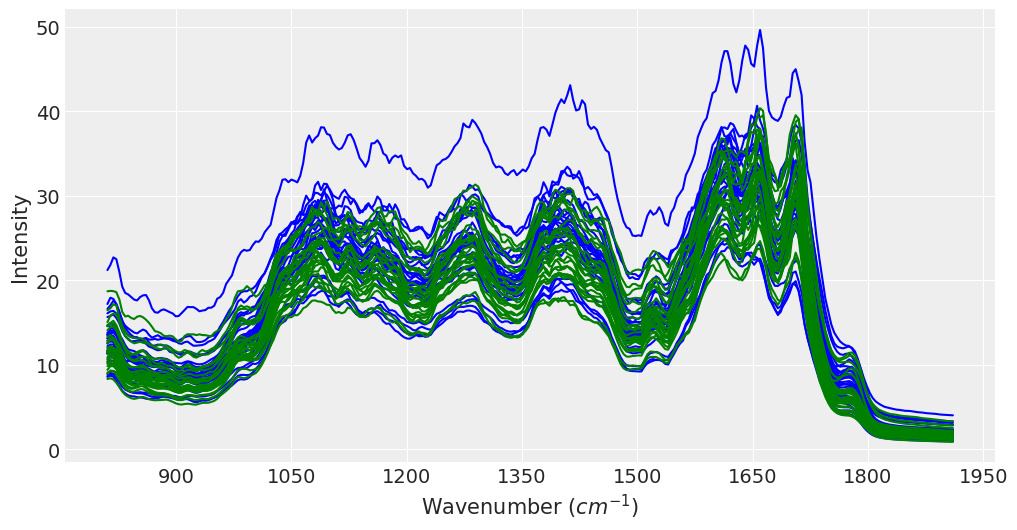

In [116]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

# Model definition (Multiple Logistic Regression)

In [118]:
# standardize data
Y = pd.Categorical(data['label']).codes
x_n = data.columns[:-2]
x_s = data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(56, 286)

In [74]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [07:07<00:00,  5.96it/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


In [75]:
#pm.model_to_graphviz(model_mlr)

# Model evaluation

In [76]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

/home/johan/VirtualEnv/pymc3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
alpha,-2.94,10.04,0.15,-21.67,16.75,2357.0,1.0
beta[0],0.32,9.66,0.11,-18.49,17.69,3412.0,1.0
beta[1],1.23,9.48,0.13,-17.23,18.20,3868.0,1.0
beta[2],0.96,9.97,0.09,-17.50,19.87,4362.0,1.0
beta[3],1.18,9.75,0.21,-17.06,18.79,3003.0,1.0
beta[4],1.03,9.85,0.10,-16.67,20.10,3429.0,1.0
beta[5],0.72,9.66,0.09,-18.35,18.14,3284.0,1.0
beta[6],0.89,9.72,0.17,-17.31,19.75,3546.0,1.0
beta[7],0.73,9.88,0.15,-18.11,18.40,2768.0,1.0
beta[8],0.66,9.69,0.20,-17.23,18.81,2723.0,1.0


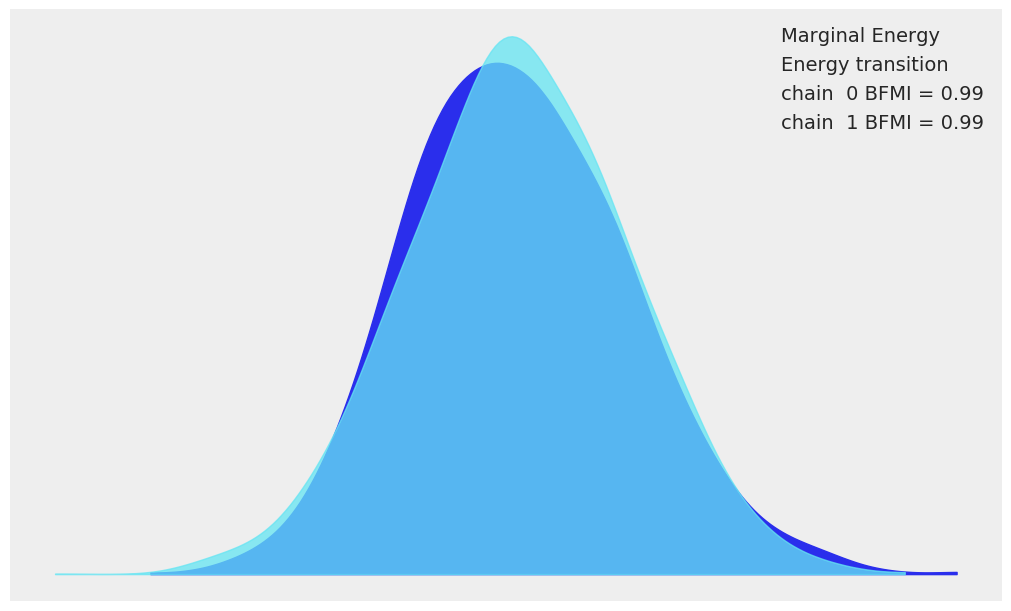

In [77]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [101]:
# check predictions 
from scipy.special import expit as logistic

p_y = np.zeros(len(x_s))
lp = [] 

y_pred = trace_mlr['theta'].mean(0)

for i in range(len(x_s)):
    if (y_pred[i] < 0.5): 
        p_y[i] = 0
        lp.append('Arabica')
    else:
        p_y[i] = 1
        lp.append('Robusta')

# add new colums to dataframe
data = data.assign(pred=pd.Series(p_y))
data = data.assign(pred_label=pd.Series(lp))
data.iloc[:,-4:]

,code,label,pred,pred_label
0,1,Arabica,0.0,Arabica
1,1,Arabica,0.0,Arabica
2,1,Arabica,0.0,Arabica
3,1,Arabica,0.0,Arabica
4,1,Arabica,0.0,Arabica
5,1,Arabica,0.0,Arabica
6,1,Arabica,0.0,Arabica
7,1,Arabica,0.0,Arabica
8,1,Arabica,0.0,Arabica
9,1,Arabica,0.0,Arabica


In [145]:
# prediction score
c = 0
for i in range(len(x_s)):
    if data['label'][i] == lp[i]:
        c += 1
        
f'{c / len(Y):.2f}'

'1.00'

### TODO: 
- Split data in training and validation set